In [1]:
import datetime

from ismn.interface import ISMN_Interface
import numpy as np
import pandas as pd
import math
import os
import geopandas as gpd
from shapely.geometry import Point
import shutil
import glob

In [6]:
## 注意查看这里的数据源，e:\ismn是最新的
#data_path = r"/share/yangjunran/Data_separate_files_19500101_20220407_9419_21BN_20220407/"
# data_path = r"D:/dataset/Data_separate_files_19500101_20220407_9419_21BN_20220407/"
data_path = r"E:\ismn"
# data_path = r"E:\ismn"
#data_path = r"D:/dataset/my_test/"
ismn_data = ISMN_Interface(data_path, parallel=True)

Found existing ismn metadata in E:\ismn\python_metadata\ismn.csv.


d:\anaconda3\envs\s_m\lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


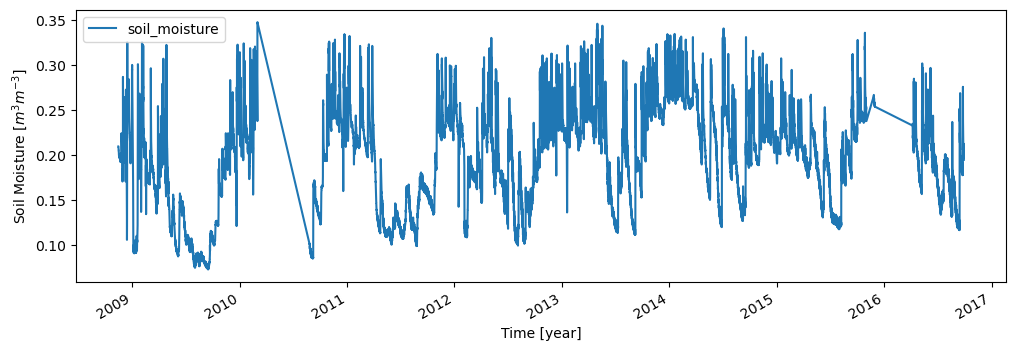

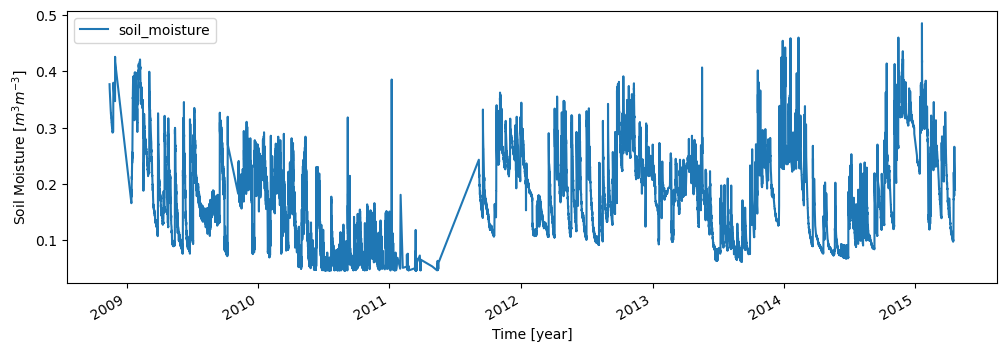

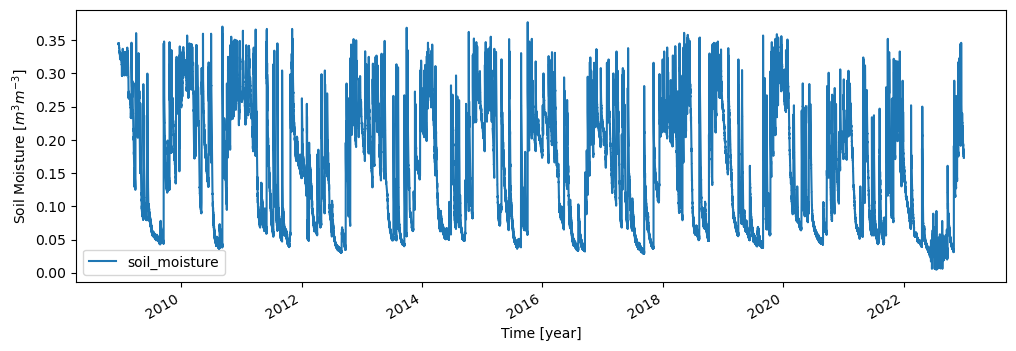

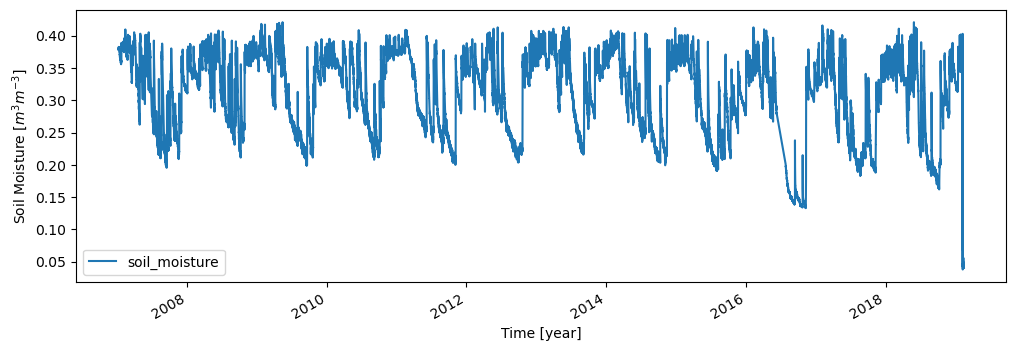

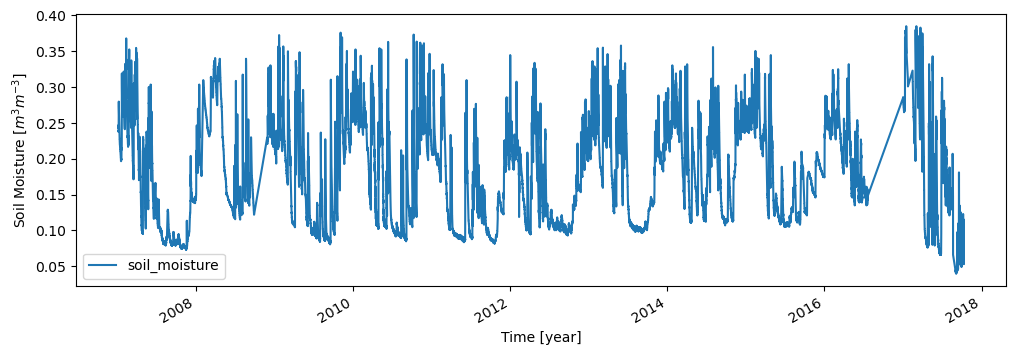

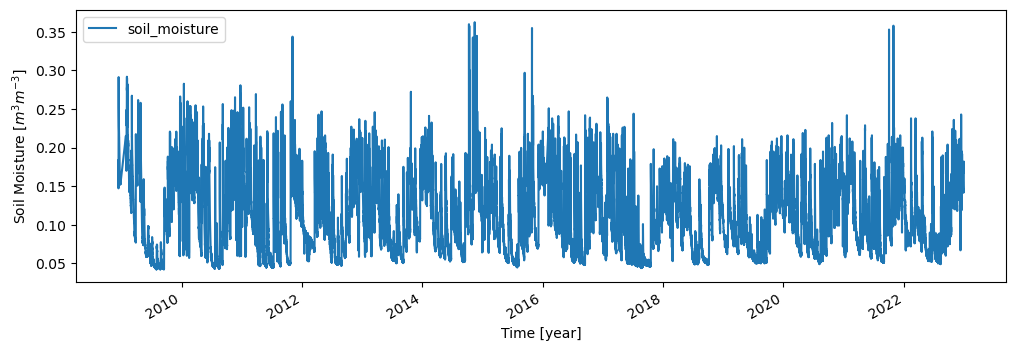

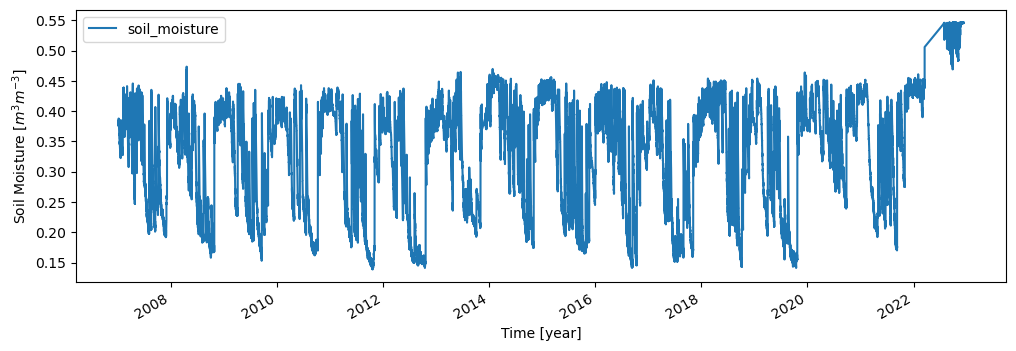

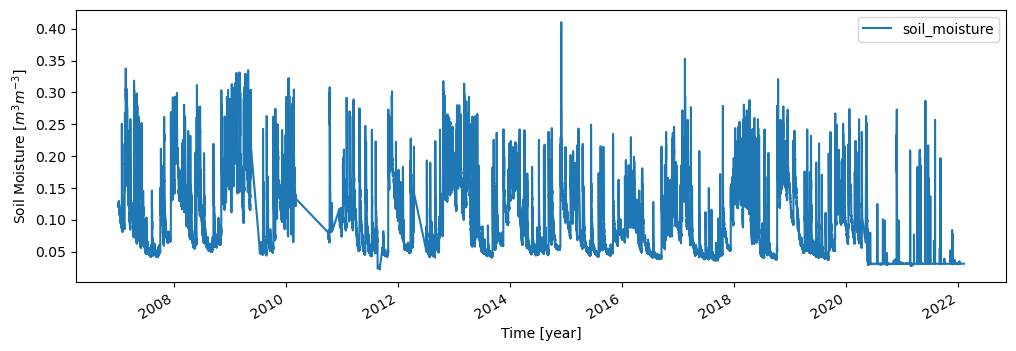

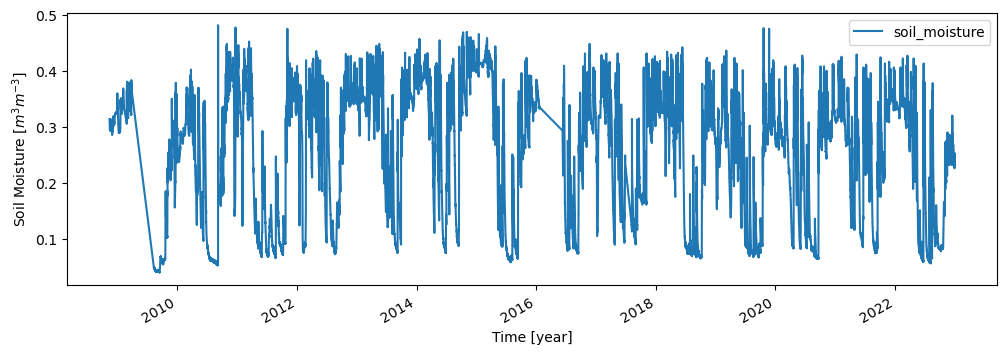

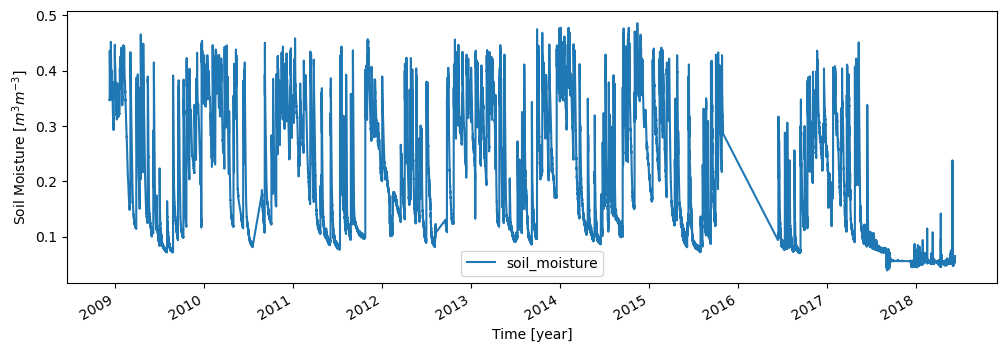

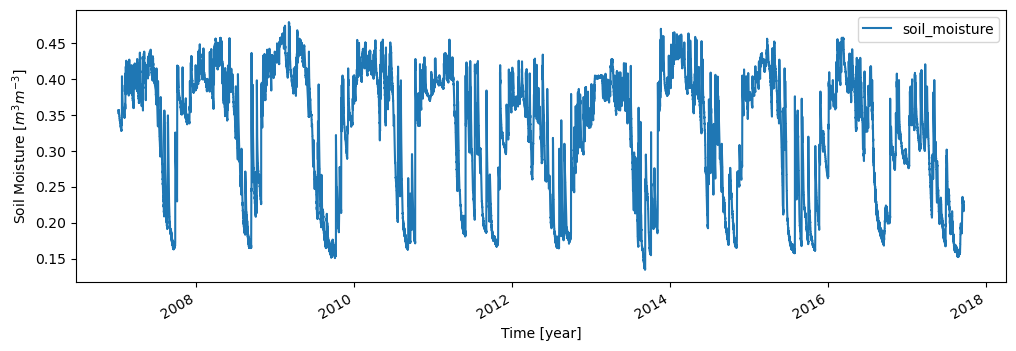

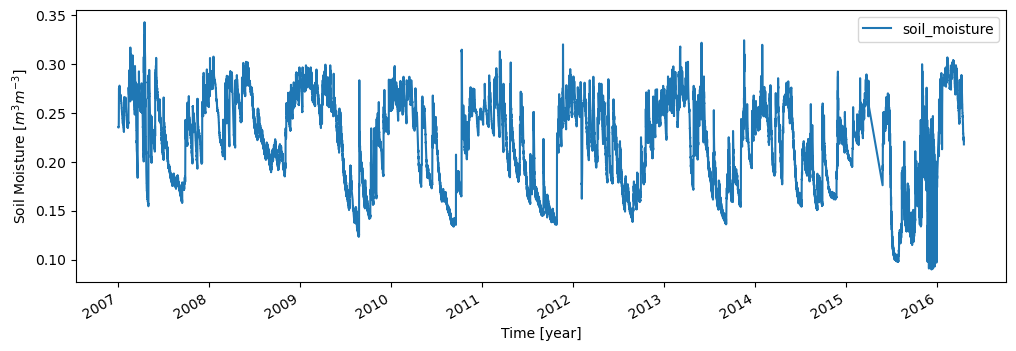

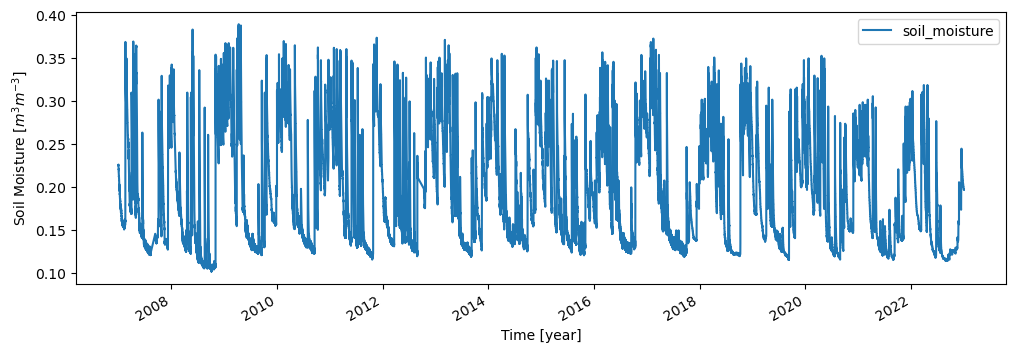

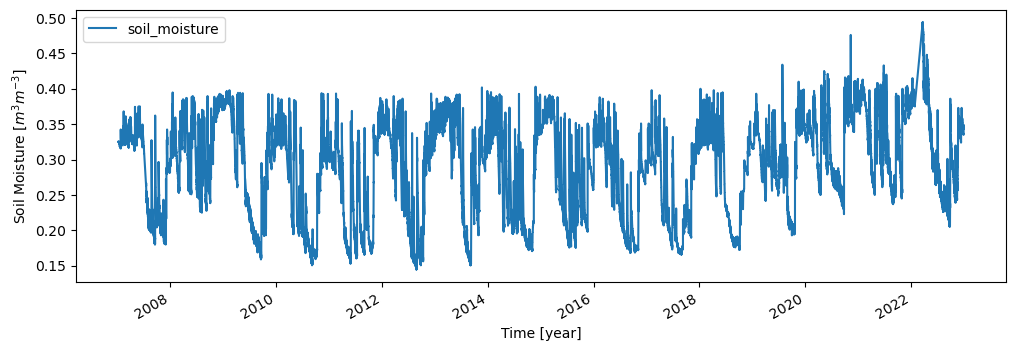

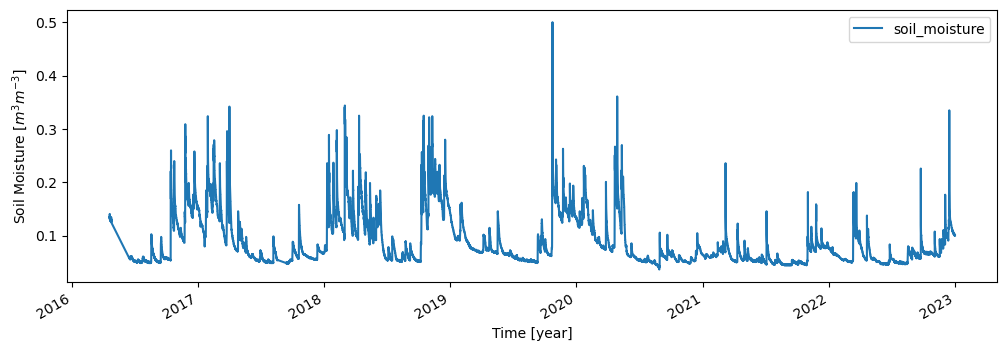

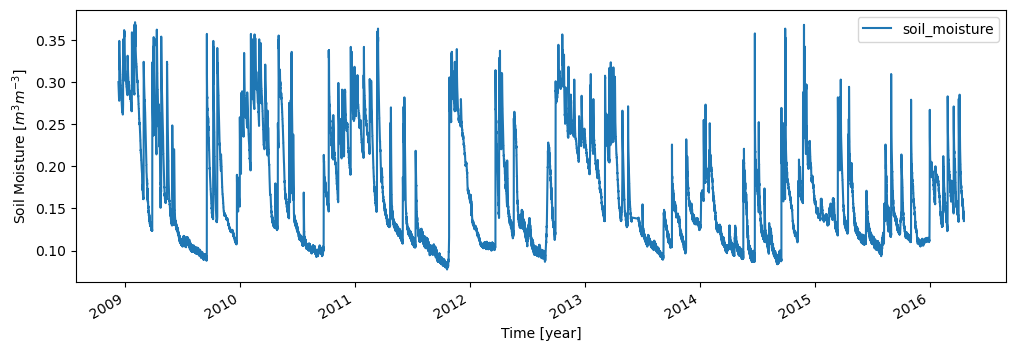

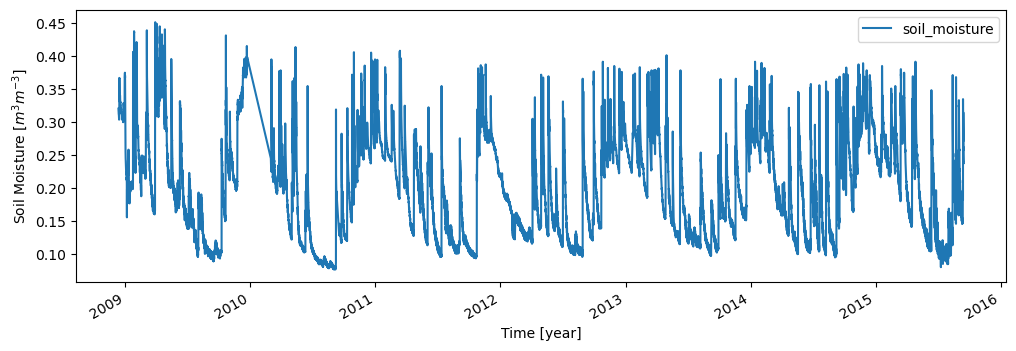

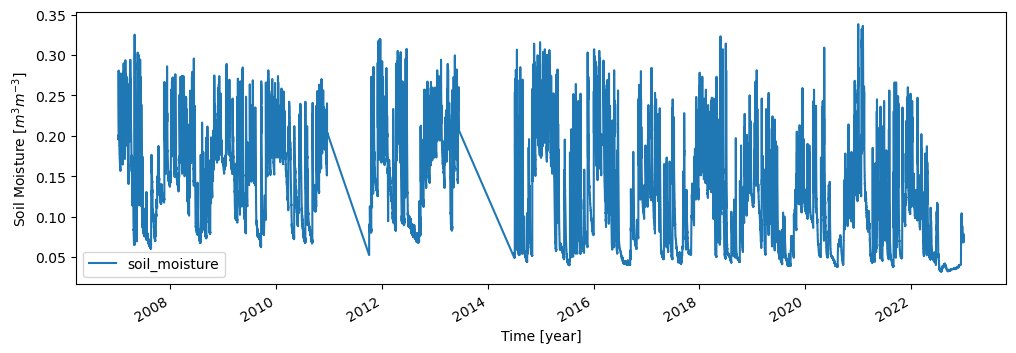

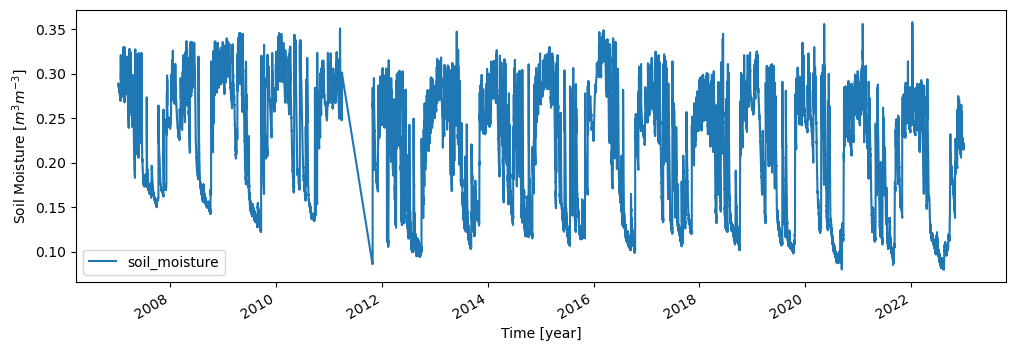

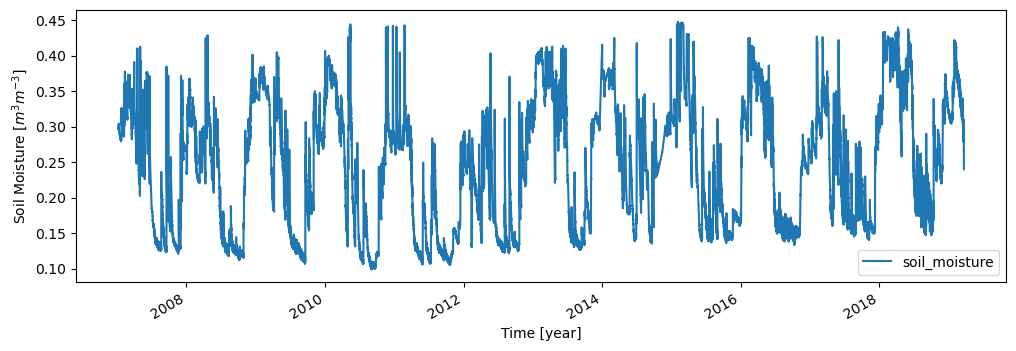

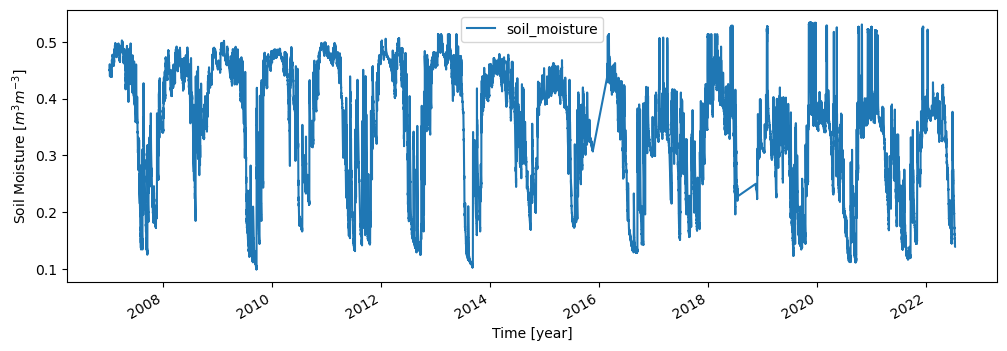

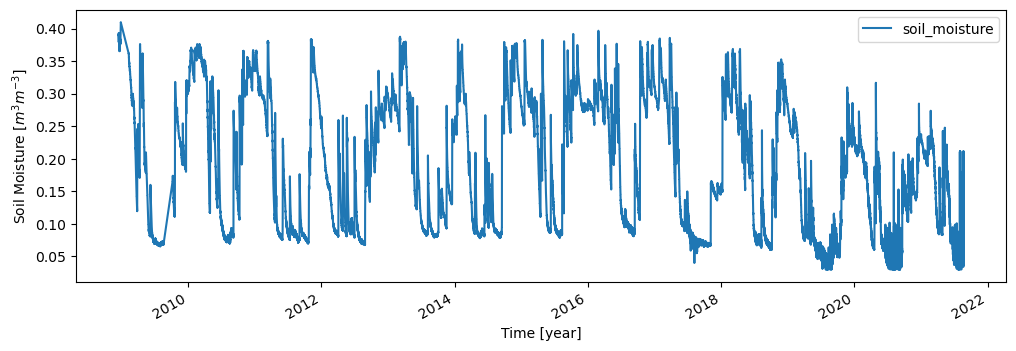

In [8]:
for i in range (22):
    sensor = ismn_data['SMOSMANIA'][i][0]
    #print(sensor.metadata.to_pd())
    ax = sensor.data.plot(figsize=(12,4))
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")

In [11]:
# 遍历ismn_data的所有站点 并将其中的站点所属网络、站点名称、站点坐标信息保存至csv文件中
def get_sensors_location(ismn_data):
    k = 1
    # df = pd.DataFrame(columns=['network', 'station', 'depth_from', 'depth_to', 'start_date', 'end_date'])
    df = pd.DataFrame(columns=['network', 'station', 'lon','lat'])
    # 遍历ismn_data的所有站点（collection可替换为具体站点）
    # iter_stations()返回的是一个元组，第一个元素是network，第二个元素是station
    # 如果是iter_sensors()，则返回的是一个元组，第一个元素是network，第二个元素是station, 第三个元素是sensor
    for network, station in ismn_data.collection.iter_stations():
        network_name = network.name
        s = station.name
        m = station.metadata
        lon = m['longitude'].val
        lat = m['latitude'].val
        df.loc[k] = [network_name, s, lon,lat]
        if k % 100 == 0:
            print('Had processed', k)
        k += 1
    df.to_csv(r'D:\dataset\mutifusion_sta_data\ismn_all_points.csv',mode="w")#mode="w"为覆盖

# 生成一次即可
#get_sensors_location(ismn_data)

In [19]:
# 根据需要提供的站点信息提取对应站点所需要的时段内的土壤水csv数据
# 输入：
    # station: 站点
    # start_time: 开始时间
    # end_time: 结束时间
    # depth_from: 数据深度的下限
    # depth_to: 数据深度的上限
    # depth_choose: 选择的数据深度
    # day_mean: 是否对数据进行日均处理
# 输出：
    # sensor_data: 选择的传感器数据【dataframe类型，time，sm两列】
    # sensor: 选择的传感器信息
def get_sensor_data(station,start_time,end_time,depth_from,depth_to,depth_choose,day_mean=False):
    sensor_depth = []
    
    sensor_list = station.get_sensors(variable='soil_moisture',depth_from=depth_from,depth_to=depth_to)
    if len(sensor_list) == 0:
        return None
    
    elif len(sensor_list)>1:
        for sensor in sensor_list:
            #print(sensor.read_data()[start_time:end_time])
            # 这段一直报错是因为，read_data()返回的一共有3列，分别是soil_moisture，soil_flag，soil_xxx_quality_flag
            if len(sensor.read_data()[start_time:end_time]['soil_moisture'].resample('D').mean()) > 1000:
                sensor_depth.append(sensor.depth.end)
            else:
                sensor_depth.append(-999)
                # print(sensor.name)
        sensor_depth = np.array(sensor_depth)
        # sensor = sensor_list[np.argmin(abs(sensor_depth-0.07))]  # 0.07可能需要随选择的数据深度调整
        sensor = sensor_list[np.argmin(abs(sensor_depth-depth_choose))]  # depth_choose可能需要随选择的数据深度调整
    else:
        sensor = sensor_list[0]
        
    sensor_data = sensor.read_data()
    # example: sensor_data = sensor_data["2011-01-01":"2017-01-01"]
    sensor_data = sensor_data[start_time:end_time]['soil_moisture']
    if day_mean:
        sensor_data = sensor_data.resample('D').mean()
    return sensor_data,sensor

In [13]:
# # 未使用
# # 根据站点提取土壤水数据
# points = pd.read_csv(r"D:\dataset\mutifusion_sta_data\ismn_all_points.csv")

# def get_point_csv(base_dir,points,ismn_data,start_time,end_time,depth_from=0,depth_to=0.11,day_mean=None):
#     """
#     :param base_dir: 数据存储路径
#     :param points: 站点信息
#     :param ismn_data: 数据集
#     :param start_time: 开始时间
#     :param end_time: 结束时间
#     :param day_mean: 是否按天计算平均值
#     """
#     for index, point in points.iterrows():
#         station = point['station']
#         network = point['network']
        
#         station = ismn_data.collection[network][station]
        
#         sensor_information = get_sensor_data(station,start_time,end_time,depth_from,depth_to,day_mean)
        
#         if sensor_information is None:
#             continue
#         sensor_data,sensor = sensor_information
        
#         station_dir = ("%s/%s/")%(base_dir,point["station"])
        
#         # 舍弃时间区间内缺失过于严重的站点
#         if len(sensor_data)<1000:
#             continue
        
#         if not os.path.exists(station_dir):
#             os.mkdir(station_dir)

#         sensor_data.to_csv(("%s/%s.csv")%(station_dir,sensor.name),index=False)
#         point.to_csv(("%s/%s_intro.txt")%(station_dir,sensor.name),index=False)

In [21]:
# 根据shp文件提取范围内的站点
# 读取黄河流域shp文件
qtp = gpd.read_file(r"D:\dataset\mutifusion_sta_data\huang_river_basin_shp\huang_river.shp")
# 输出目录
base_dir = r'D:\dataset\mutifusion_sta_data\ismn_sites'
# 时段范围选取
start_time,end_time = '1950-01-01','2021-01-01'
# 深度范围选取
depth_from,depth_to = 0,0.11
# 实际深度选取（最近argmin）
depth_choose = 0.07
# 是否按天计算平均值
day_mean = True

# 读取全部站点坐标
points = pd.read_csv(r"D:\dataset\mutifusion_sta_data\ismn_all_points.csv")

# 创建要判断的坐标点
for index, point in points.iterrows():
    lon,lat = point['lon'],point['lat']

    judge_point = Point(lon,lat)

    # 判断坐标点是否在黄河流域内
    if qtp.contains(judge_point).any():
        station = point['station']
        network = point['network']
        station = ismn_data.collection[network][station]

        # 站点各类属性数据
        station_intro = station.metadata.to_pd()
        
        sensor_information = get_sensor_data(station,start_time,end_time,depth_from,depth_to,depth_choose,day_mean)
        
        if sensor_information is None:
            continue
        sensor_data,sensor = sensor_information
        
        station_dir = ("%s/%s/")%(base_dir,point["station"])
        
        if not os.path.exists(station_dir):
            os.mkdir(station_dir)

        sensor_data.to_csv(("%s/%s.csv")%(station_dir,sensor.name))
        sensor_data.to_csv(("%s/ismn.csv")%(station_dir))
        station_intro.to_csv(("%s/%s_intro.txt")%(station_dir,sensor.name))
        station_intro.to_csv(("%s/%s_intro.txt")%(station_dir,point["station"]))
        # 如果想从intro读取站点的经纬度、气候、土地覆盖类型，可以使用下面的代码
        # df = pf.read_csv('intor.txt')
        # climate_KG = df[df['variable']=='climate_KG']['data'].values[0]
        # lc_2000 = df[df['variable']=='lc_2000']['data'].values[0]
        # lon = df[df['variable']=='longitude']['data'].values[0]
        # lat = df[df['variable']=='latitude']['data'].values[0]

C:\Users\pc\AppData\Local\Temp\ipykernel_23956\1342298562.py:16: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  sensor_list = station.get_sensors(variable='soil_moisture',depth_from=depth_from,depth_to=depth_to)
C:\Users\pc\AppData\Local\Temp\ipykernel_23956\1342298562.py:16: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  sensor_list = station.get_sensors(variable='soil_moisture',depth_from=depth_from,depth_to=depth_to)
C:\Users\pc\AppData\Local\Temp\ipykernel_23956\1342298562.py:16: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  sensor_list = station.get_sensors(variable='soil_moisture',depth_from=depth_from,depth_to=depth_to)
C:\Users\pc\AppData\Local\Temp\ipykernel_23956\1342298562.py:16: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  sensor_list = station.ge